In [1]:
%reload_ext autoreload
%reload_ext rpy2.ipython

%autoreload 2
%matplotlib inline

import sys
sys.path.append('../src')

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

sns.set_style('white')

# PAM50 clustering

## Datasets

### Mouse dataset

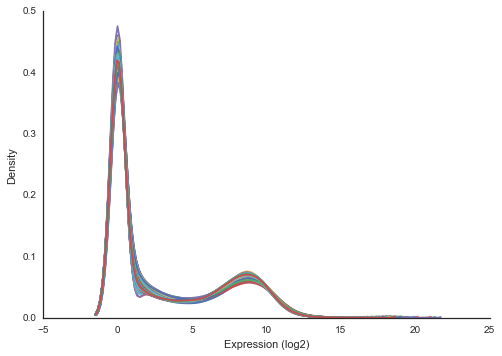

In [2]:
import genemap
from nbsupport.expression.util import normalize_counts, plot_count_distribution

samples = pd.read_csv('../data/raw/sb/samples.txt', sep='\t')

# Read counts.
def read_tsv(file_path, *args, index_col=0, **kwargs):
    """Helper function for reading indexed tsv files."""
    return pd.read_csv(file_path, sep='\t', index_col=index_col)

sb_counts = read_tsv('../data/processed/sb/rnaseq/gene_counts.txt')
kb1p_counts = read_tsv('../data/processed/kb1p/gene_counts.txt')
pten_counts = read_tsv('../data/processed/pten/gene_counts.txt')

# Translate SB ids to names.
name_map = dict(zip(samples['rnaseq_id'], samples['sample']))
sb_counts = sb_counts.rename(columns=name_map)

# Merge the datasets.
mouse_counts = pd.concat([sb_counts, kb1p_counts, pten_counts], axis=1)
mouse_counts.dropna(inplace=True)

# Translate to symbols.
mouse_counts = genemap.map_frame(
    mouse_counts, from_type='ensembl', to_type='symbol',
    from_organism='mmusculus', mapper='ensembl')

# Normalize for depth and log transform.
mouse_expr = normalize_counts(mouse_counts)
mouse_expr = np.log2(mouse_expr + 1)

# Define mouse design frame.
def _mouse_model(sample):
    if sample in kb1p_counts.columns:
        return 'Basal-like'
    elif sample in pten_counts.columns:
        return 'Luminal'
    else:
        return 'SB'

mouse_design = pd.DataFrame({
    'sample': mouse_expr.columns,
    'mouse_model': [_mouse_model(s) for s in  mouse_expr.columns],
    'organism': 'mouse',
}).set_index('sample')

# Plot distribution of counts for QC.
plot_count_distribution(mouse_expr);

### TCGA dataset

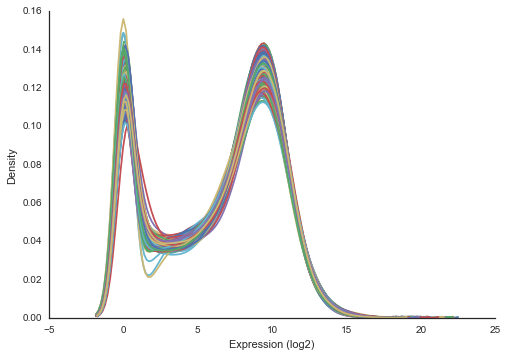

In [3]:
# Read and log transform counts.
tcga_expr = pd.read_csv('../data/external/tcga-expression.normalized.txt',
                        sep='\t', index_col=0)
tcga_expr = np.log2(tcga_expr + 1)
    
# Build human design matrix.
tcga_design = read_tsv('../data/external/tcga-breast-2012/BRCA.547.PAM50.SigClust.Subtypes.txt')[['PAM50']]
tcga_design.rename(columns=dict(PAM50='subtype'), inplace=True)
tcga_design['organism'] = 'human'

# Convert PAM50 to (ordered) categorical.
pam50_order = ['LumA', 'LumB', 'Her2', 'Basal', 'Normal']
tcga_design['subtype'] = pd.Categorical(tcga_design['subtype'], categories=pam50_order)

# Subset to common samples.
common_samples = list(set(tcga_expr.columns) & set(tcga_design.index))

tcga_expr = tcga_expr[common_samples]
tcga_design = tcga_design.ix[common_samples]

# QC plot.
plot_count_distribution(tcga_expr);

### Combined human/mouse dataset

In [4]:
# Map TCGA expression to mouse symbols.
tcga_expr_mm = genemap.map_frame(
    tcga_expr, from_type='symbol', to_type='symbol',
    from_organism='hsapiens', to_organism='mmusculus', mapper='ensembl')

# Combine mouse and human datasets.
combined_expr = pd.concat([mouse_expr, tcga_expr_mm], axis=1).dropna()
combined_design = pd.concat([mouse_design, tcga_design], axis=0)

## Clustering

In [6]:
# Read list of pam50 genes.
with open('../data/external/tcga-breast-2012/pam50_genes.txt') as file_:
    pam50_human = [line.strip() for line in file_]
    
# Map to mouse symbols.
pam50_mouse = genemap.map_ids(
    pam50_human, from_type='symbol', to_type='symbol',
    from_organism='hsapiens', to_organism='mmusculus', mapper='ensembl')
pam50_mouse = [gene for gene in pam50_mouse if gene is not None]

print('Missing genes: {}'.format(len(pam50_human) - len(pam50_mouse)))

Missing genes: 4


In [13]:
from nbsupport.expression.combat import combat

combat_expr = combat(combined_expr, batch=combined_design['organism'])

Found
 
2
 
batches

Adjusting for
 
0
 
covariate(s) or covariate level(s)

Standardizing Data across genes

Fitting L/S model and finding priors

Finding parametric adjustments

Adjusting the Data



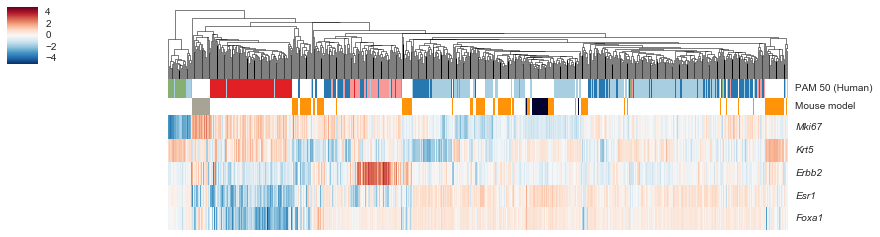

In [31]:
from nbsupport.expression.pam50 import plot_pam50

zoom_genes = ['Mki67', 'Krt5', 'Erbb2', 'Esr1', 'Foxa1']
plot_pam50(combat_expr, combined_design, genes=pam50_mouse, 
           subset=zoom_genes, figsize=(14, 4), row_cluster=False,
           col_ratios={'side_colors': 0.25, 'dendrogram': 0.5}, 
           vmax=5, vmin=-5)

with sns.plotting_context('paper', font_scale=0.7):
    cm = plot_pam50(
        combat_expr, combined_design, genes=pam50_mouse, 
        subset=zoom_genes, figsize=(11, 2), row_cluster=False,
        col_ratios={'side_colors': 0.25, 'dendrogram': 0.5},
        vmax=5, vmin=-5)
    cm.savefig('../reports/figures/fig_2_pam50_zoom.pdf', bbox_inches='tight')
    plt.close(cm.fig)

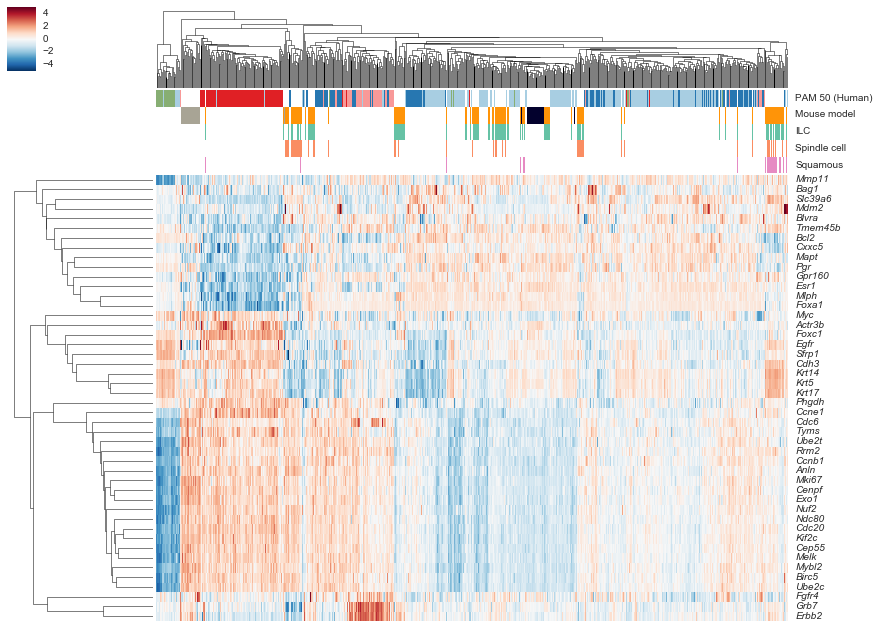

In [125]:
from nbsupport.morphology import parse_morphology, MORPHOLOGY_COLORS
from nbsupport.util.clustermap import color_annotation

morphology = parse_morphology(samples)
morphology_ann = color_annotation(morphology, MORPHOLOGY_COLORS)[0]

plot_pam50(
    combat_expr, combined_design, genes=pam50_mouse, 
    figsize=(14, 11), col_ratios={'side_colors': 0.15},
    extra_annotation=morphology_ann, vmin=-5, vmax=5)

with sns.plotting_context('paper', font_scale=0.7):
    cm = plot_pam50(
        combat_expr, combined_design, genes=pam50_mouse, 
        figsize=(7, 6), col_ratios={'side_colors': 0.15},
        extra_annotation=morphology_ann, vmin=-5, vmax=5)
    cm.savefig('../reports/supplemental/figures/fig_s2_pam50_tgca.pdf', bbox_inches='tight')
    plt.close(cm.fig)

# Subtype analysis

## NMF factorization

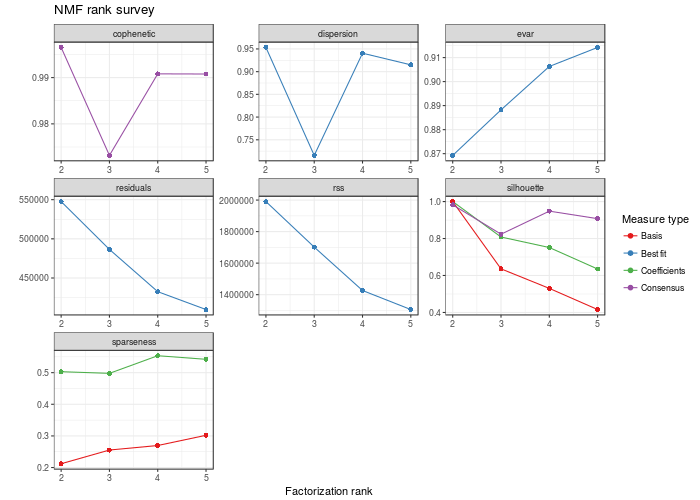

In [33]:
%%R -w 700 -h 500

suppressPackageStartupMessages(library(NMF))

est_rank = readRDS('../data/processed/sb/nmf/rank_estimation.rds')
plot(est_rank)

## Naming the subtypes

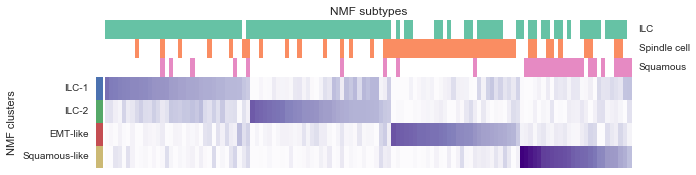

In [78]:
from nbsupport.expression.subtypes import plot_nmf_subtypes

# Read NMF coefficients and map names.
nmf_coef = pd.read_csv('../data/processed/sb/nmf/coefficients.txt', sep='\t')
nmf_coef.index = [name_map[i] for i in nmf_coef.index]

# Plot with putative subtype names.
nmf_coef.columns = ['ILC-1', 'ILC-2', 'EMT-like', 'Squamous-like']
plot_nmf_subtypes(nmf_coef, morphology, figsize=(12, 3))

with sns.plotting_context('paper', font_scale=0.7):
    cm = plot_nmf_subtypes(nmf_coef, morphology, figsize=(9.8, 1.5))
    cm.ax_col_colors.annotate('Morphology', xy=(1.011, 1.06), 
                              xycoords='axes fraction', fontsize=6)
    cm.savefig('../reports/figures/fig_2_nmf_coef.pdf', bbox_inches='tight')
    plt.close(cm.fig)

In [79]:
from IPython.display import display

from nbsupport.expression.subtypes import assign_nmf_subtypes
from nbsupport.enrichment.associations import test_associations

# Assign samples to (putatively named) subtypes.
nmf_subtypes = assign_nmf_subtypes(nmf_coef)

# Test enrichment with morphology.
result = test_associations(
    nmf_subtypes[['subtype']],
    morphology, alternative='greater')

print('Subtypes')
display(result.query('p_value_corr < 0.05'))

# Test enrichment with merged ILC clusters.
merge_map = {'ILC-1': 'ILC', 'ILC-2': 'ILC'}
nmf_subtypes['subtype_merged'] = nmf_subtypes['subtype'].map(
    lambda s: merge_map.get(s, s))

result_merged = test_associations(
    nmf_subtypes[['subtype_merged']],
    morphology, alternative='greater')

print('Merged ILC subtypes')
display(result_merged.query('p_value_corr < 0.05'));

Subtypes


,a,b,p_value,p_value_corr
1,subtype_EMT-like,Spindle cell,2.969342e-12,1.781605e-11
3,subtype_ILC-1,ILC,2.055167e-03,6.165502e-03
6,subtype_ILC-2,ILC,2.097109e-04,8.388438e-04
11,subtype_Squamous-like,Squamous,2.430269e-12,1.781605e-11


Merged ILC subtypes


,a,b,p_value,p_value_corr
1,subtype_merged_EMT-like,Spindle cell,2.969342e-12,1.336204e-11
3,subtype_merged_ILC,ILC,1.032407e-08,3.097222e-08
8,subtype_merged_Squamous-like,Squamous,2.430269e-12,1.336204e-11


In [142]:
nmf_subtypes.to_csv('../data/processed/sb/nmf/subtypes.txt', sep='\t')

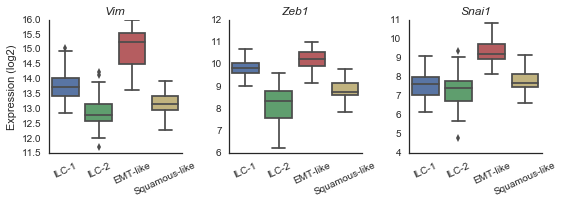

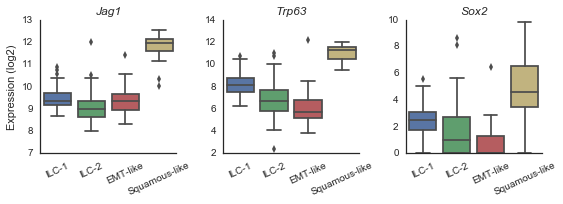

In [118]:
from nbsupport.expression.subtypes import plot_boxplots

# Subset expression to SB samples.
sb_expr = mouse_expr[sb_counts.columns]

# Plot EMT gene expression.
emt_genes = ['Vim', 'Zeb1', 'Snai1']

fig, axes = plot_boxplots(
    sb_expr, nmf_subtypes,
    genes=emt_genes, figsize=(8, 3))
axes[0, 0].set_ylabel('Expression (log2)');

# Plot Squamous gene expression.
squamous_genes = ['Jag1', 'Trp63', 'Sox2']

fig, axes = plot_boxplots(
    sb_expr, nmf_subtypes,
    genes=squamous_genes, figsize=(8, 3))
axes[0, 0].set_ylabel('Expression (log2)');

In [141]:
with sns.plotting_context('paper', font_scale=0.7):
    # Plot EMT gene expression.
    fig, axes = plot_boxplots(
        sb_expr, nmf_subtypes,
        genes=emt_genes, figsize=(3.5, 1.4),
        linewidth=0.5, fliersize=2)
    axes[0, 0].set_ylabel('Expression (log2)');
    
    fig.suptitle('EMT marker genes', y=1.05, fontsize=7)
    fig.savefig('../reports/supplemental/figures/fig_s2_emt_genes.pdf',
                bbox_inches='tight')  
    
    plt.close(fig)

    # Plot Squamous gene expression.
    fig, axes = plot_boxplots(
        sb_expr, nmf_subtypes,
        genes=squamous_genes, figsize=(3.5, 1.4),
        linewidth=0.5, fliersize=2)
    axes[0, 0].set_ylabel('Expression (log2)');

    fig.suptitle('Squamous marker genes', y=1.05, fontsize=7)
    fig.savefig('../reports/supplemental/figures/fig_s2_squamous_genes.pdf',
                bbox_inches='tight')
    
    plt.close(fig)

## PAM50 expression across subtypes

In [135]:
?sns.boxplot(np.random.uniform((4, 4)), linewidth=0.5)

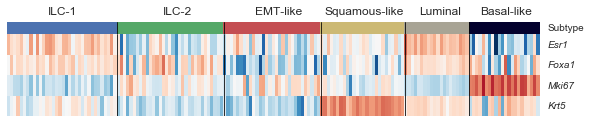

In [87]:
from nbsupport.expression.subtypes import SUBTYPE_ORDER, SUBTYPE_COLORS, plot_heatmap

# Combine expression with subtypes.
mouse_subtypes = pd.concat([mouse_design, nmf_subtypes['subtype']], axis=1)
mouse_subtypes.ix[mouse_subtypes['mouse_model'] == 'Basal-like', 'subtype'] = 'Basal-like'
mouse_subtypes.ix[mouse_subtypes['mouse_model'] == 'Luminal', 'subtype'] = 'Luminal'

# Plot heatmap.
selected_pam50_genes = ['Esr1', 'Foxa1', 'Mki67', 'Krt5']

mouse_order = ['Luminal', 'Basal-like']
mouse_colors = sns.color_palette(sns.xkcd_palette(['greyish', 'midnight']))

combined_order = SUBTYPE_ORDER + mouse_order
combined_colors = SUBTYPE_COLORS + mouse_colors

cm = plot_heatmap(
    mouse_expr, mouse_subtypes, 
    genes=selected_pam50_genes,
    figsize=(12, 2), col_cluster=False,
    order=combined_order, palette=combined_colors,
    col_ratios={'side_colors': 0.12}, colorbar=False)

cm.fig.text(x=0.33, y=0.83, s='ILC-1')
cm.fig.text(x=0.463, y=0.83, s='ILC-2')
cm.fig.text(x=0.57, y=0.83, s='EMT-like')
cm.fig.text(x=0.65, y=0.83, s='Squamous-like')
cm.fig.text(x=0.760, y=0.83, s='Luminal')
cm.fig.text(x=0.830, y=0.83, s='Basal-like');

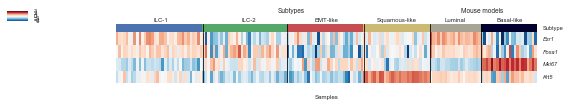

In [110]:
with sns.plotting_context('paper', font_scale=0.7):
    cm = plot_heatmap(
        mouse_expr, mouse_subtypes,
        genes=selected_pam50_genes,
        figsize=(9.5, 1.3), col_cluster=False,
        order=combined_order, palette=combined_colors,
        col_ratios={'side_colors': 0.12}, colorbar=True,
        vmax=3, vmin=-3)
    
    cm.ax_heatmap.set_xlabel('Samples')

    cm.fig.text(x=0.35, y=0.79, s='ILC-1', ha='center', fontsize=6)
    cm.fig.text(x=0.478, y=0.79, s='ILC-2', ha='center', fontsize=6)
    cm.fig.text(x=0.592, y=0.79, s='EMT-like', ha='center', fontsize=6)
    cm.fig.text(x=0.695, y=0.79, s='Squamous-like', ha='center', fontsize=6)
    cm.fig.text(x=0.78, y=0.79, s='Luminal', ha='center', fontsize=6)
    cm.fig.text(x=0.86, y=0.79, s='Basal-like', ha='center', fontsize=6)
    
    cm.fig.text(x=0.54, y=0.89, s='Subtypes', ha='center', fontsize=6.5)
    cm.fig.text(x=0.82, y=0.89, s='Mouse models', ha='center', fontsize=6.5)
    
    cm.savefig('../reports/figures/fig_2_pam50_heatmap.pdf', bbox_inches='tight')

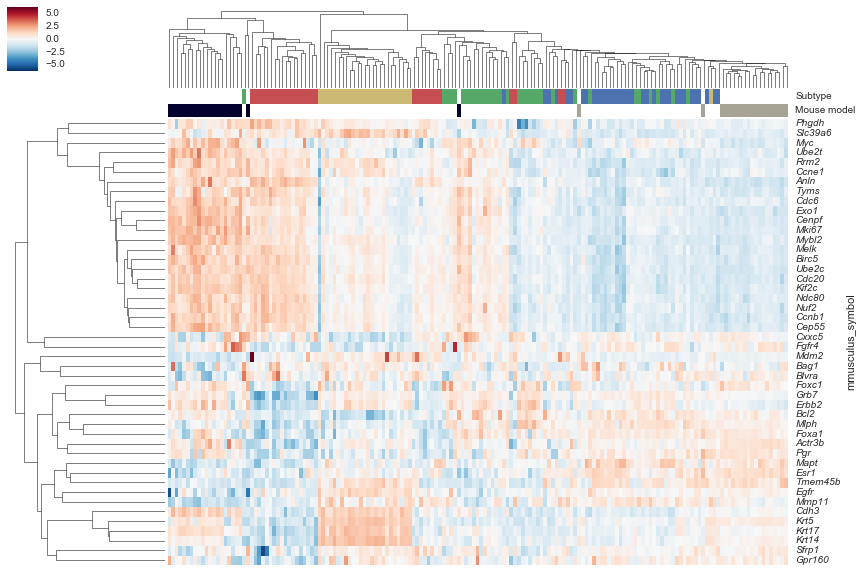

In [120]:
from nbsupport.util.seaborn import clustermap

mouse_subtypes2 = (
    pd.concat([
        (nmf_subtypes['subtype'].astype('category', categories=SUBTYPE_ORDER)),
        (mouse_design['mouse_model']
             .replace('SB', np.nan)
             .astype('category', categories=mouse_order))
    ], axis=1)
    .rename(columns=lambda c: c.replace('_', ' ').capitalize()))

mouse_annotation, mouse_cmaps = color_annotation(
    mouse_subtypes2, [SUBTYPE_COLORS, mouse_colors])

cm = clustermap(
    mouse_expr.ix[pam50_mouse], z_score=0, 
    method='average', col_colors=mouse_annotation, figsize=(14, 10))
cm.ax_heatmap.set_xticklabels([])
plt.setp(cm.ax_heatmap.get_yticklabels(), rotation=0, fontstyle='italic');
    #legend_cmaps=[mouse_cmaps], legend_kws={'position': (1.3, 1), 'offset': 0.3})

In [121]:
with sns.plotting_context('paper', font_scale=0.7):
    cm = clustermap(
        mouse_expr.ix[pam50_mouse], z_score=0, 
        method='average', col_colors=mouse_annotation, figsize=(14, 10))
    cm.ax_heatmap.set_xticklabels([])
    cm.ax_heatmap.set_ylabel('Genes')
    cm.ax_heatmap.set_xlabel('Samples')
    plt.setp(cm.ax_heatmap.get_yticklabels(), rotation=0, fontstyle='italic');
    
    cm.savefig('../reports/supplemental/figures/fig_s2_pam50_mouse.pdf', bbox_inches='tight')
    plt.close(cm.fig)

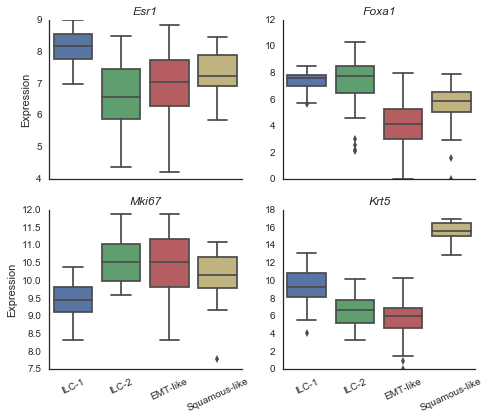

In [122]:
# Draw again as boxplot.
selected_pam50_genes = ['Esr1', 'Foxa1', 'Mki67', 'Krt5']

fig, axes = plot_boxplots(
    sb_expr, nmf_subtypes,
    genes=selected_pam50_genes, 
    figsize=(7, 6), ncols=2)

In [123]:
with sns.plotting_context('paper', font_scale=0.7):
    fig, axes = plot_boxplots(
        sb_expr, nmf_subtypes,
        genes=selected_pam50_genes, 
        figsize=(3.4, 3), ncols=2)

    for row in axes:
        row[0].set_ylabel('Expression (log2)')
        
    fig.savefig('../reports/figures/fig_2_pam50_mouse_boxplot.pdf',
                bbox_inches='tight')
    
    plt.close(fig)

## Comparison with human ILC subtypes

In [115]:
import genemap

# Read 60-gene signature and translate to mouse.
signature = (pd.read_excel('../data/external/tcga-ilc-2015/mmc9.xlsx', skiprows=2)
               .get('ILC 60 Gene Classifier').dropna()
               .map(lambda s: s.split('|')[0])
               .pipe(list))

signature_mouse = genemap.map_ids(
    signature, from_type='symbol', to_type='symbol',
    from_organism='hsapiens', to_organism='mmusculus', mapper='ensembl')

signature_mouse = list(filter(bool, signature_mouse))

In [116]:
from nbsupport.expression.combat import combat

# Read tcga expression and subtypes.
tcga_ilc_path = '../data/external/tcga-ilc-2015/ILC_rnaseqv2_RSEM_genes_normalized_data_F2.txt'
subtype_path = '../data/external/tcga-ilc-2015/mmc9.xlsx'

tcga_ilc_expr = (pd.read_csv(tcga_ilc_path, sep='\t', index_col=0)
                   .drop('?').drop('Unnamed: 128', axis=1)
                   .pipe(lambda df: np.log2(df + 1)))

tcga_subtypes = (pd.read_excel(subtype_path, skiprows=3)
                   .get(['Sample ID', 'Dataset', '60 Gene-classifier Class Assignment'])
                   .rename(columns={'Sample ID': 'sample', 'Dataset': 'dataset',
                                    '60 Gene-classifier Class Assignment': 'subtype'})
                   .assign(sample=lambda df: df['sample'].str.replace('.', '-'))
                   .dropna()
                   .query('dataset == "TCGA"')
                   .set_index('sample', drop=False))

# Map to mouse symbols and combine.
tcga_ilc_expr_mm = genemap.map_frame(
    tcga_ilc_expr, from_type='symbol', to_type='symbol',
    from_organism='hsapiens', to_organism='mmusculus', mapper='ensembl')

combined_ilc_expr = pd.concat(
    [sb_expr.ix[signature_mouse], 
     tcga_ilc_expr_mm.ix[signature_mouse]], axis=1)

# Normalize using ComBat.
combat_ilc_design = (
    pd.concat(
        [pd.DataFrame({'sample': tcga_ilc_expr_mm.columns, 'organism': 'human'}),
         pd.DataFrame({'sample': sb_expr.columns, 'organism': 'mouse'})])
    .get(['sample', 'organism']))

combat_ilc_expr = combat(combined_ilc_expr, batch=combat_ilc_design['organism'])

Found
 
2
 
batches

Adjusting for
 
0
 
covariate(s) or covariate level(s)

Standardizing Data across genes

Fitting L/S model and finding priors

Finding parametric adjustments

Adjusting the Data



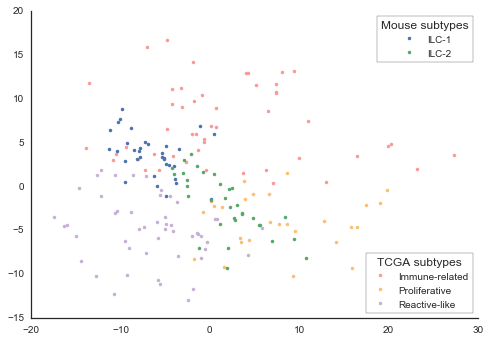

In [124]:
from sklearn.decomposition import PCA

# Fit PCA.
pca = PCA(n_components=2)
pca.fit(combat_ilc_expr.ix[signature_mouse].T)

# Apply to samples.
x_transform = pd.DataFrame(
    pca.transform(combat_ilc_expr.ix[signature_mouse].T),
    index=combat_ilc_expr.columns)

# Annotate transformation.
merged_subtypes = pd.concat([nmf_subtypes[['subtype']].assign(type='mouse'), 
                             tcga_subtypes[['subtype']].assign(type='human')])
x_transform = pd.concat([x_transform, merged_subtypes], axis=1)


def _plot_pca(ax=None):
    # Setup figure.
    if ax is None:
        _, ax = plt.subplots()

    # Plot tcga samples.
    paired_colors = sns.color_palette('Paired', 12)
    tcga_colors = [paired_colors[i] for i in [4, 6, 8]]

    tcga_labels = ['Immune-related', 'Proliferative', 'Reactive-like']

    for subtype, color in zip(tcga_labels, tcga_colors):
        grp = x_transform.ix[x_transform['subtype'] == subtype]
        ax.plot(grp[0], grp[1], '.', color=color, label=subtype)

    legend = ax.legend(loc='lower right', frameon=True, title='TCGA subtypes')
    ax.add_artist(legend)

    # Plot mouse samples.
    handles = []
    for subtype, color in zip(SUBTYPE_ORDER[:2], SUBTYPE_COLORS):
        grp = x_transform.ix[x_transform['subtype'] == subtype]
        lines = ax.plot(grp[0], grp[1], '.', color=color, label=subtype)
        handles.append(lines[0])

    ax.legend(loc='upper right', handles=handles, frameon=True, title='Mouse subtypes')
    sns.despine()
    
_plot_pca()

with sns.plotting_context('paper', font_scale=0.7):
    fig, ax = plt.subplots(figsize=(4.8, 3))
    _plot_pca(ax=ax)
    ax.set_title('PCA of human (TCGA) and mouse ILC subtypes')
    fig.savefig('../reports/figures/fig_2_human_subtypes.pdf', bbox_inches='tight')
    plt.close(fig)